**Name:** LI XINYAN

**EID:** 55670594

# CS5489 - Tutorial 5
## Predicting Bike Sharing Usage

In this tutorial you will train a regression function to predict the number people using bike sharing in each day.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)

IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)
import pandas as pd
import xgboost as xgb
from scipy import stats

## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `Bike-Sharing-Dataset.zip`, and **unzip** it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [2]:
# read the data
filename = 'Bike-Sharing-Dataset/day.csv'
df = pd.read_csv(filename)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Here are the columns in the dataset. The last 3 columns are the counts for the day.

In [3]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Here is a description of the features:
- `instant`: record index
- `dteday`: date
- `season`: season (1: winter, 2:spring, 3:summer, 4:fall)
- `yr`: year (0: 2011, 1:2012)
- `mnth`: month (1=Jan to 12=Dec)
- `holiday`: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday`: day of the week (1=Sunday to 7=Saturday)
- `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`: weather situation
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp`: Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

The first two columns are the instance number and date, which aren't useful, so we will remove them.

In [4]:
# remove first 2 columns
df.drop(columns=['instant', 'dteday'], inplace=True)

Next we will examine the distribution of the features.

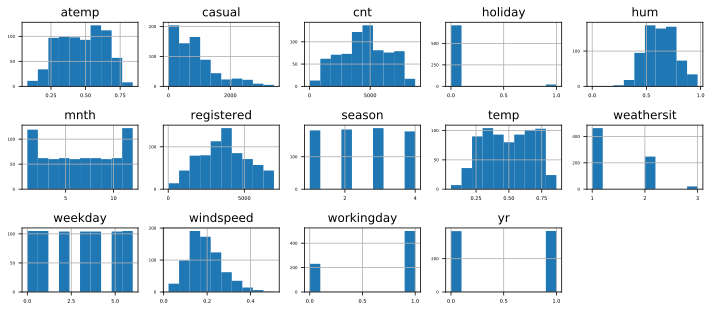

In [5]:
# show the feature distributions
foo = df.hist(layout=(14,5), figsize=(10,20), xlabelsize=5, ylabelsize=4)
plt.tight_layout()

And here are some simple statistics of the features.

In [6]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


You may notice that a few of the features are discrete values, such as `season`, `mnth`, `weekday`, and `weathersit`.  If we directly use the month feature, it may not make too much sense since adding/subtracting/multipllying 2 month numbers doesn't really mean anything related to the output. Instead, it is important which month it is.

Thus, we will convert these features into one-hot-encodings.  The original discrete features are removed, and the new features are appended to the end of the table.

In [7]:
# use pandas to create one-hot-encodings of a few colummns
dfd = pd.get_dummies(df, columns=['season', 'mnth', 'weekday', 'weathersit'])
dfd

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.344167,0.363625,0.805833,0.160446,331,654,985,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,...,1,0,0,0,0,0,0,0,1,0
2,0,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,...,0,0,1,0,0,0,0,1,0,0
4,0,0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,0,1,0.254167,0.226642,0.652917,0.350133,247,1867,2114,...,0,0,0,0,1,0,0,0,1,0
727,1,0,1,0.253333,0.255046,0.590000,0.155471,644,2451,3095,...,0,0,0,0,0,1,0,0,1,0
728,1,0,0,0.253333,0.242400,0.752917,0.124383,159,1182,1341,...,0,0,0,0,0,0,1,0,1,0
729,1,0,0,0.255833,0.231700,0.483333,0.350754,364,1432,1796,...,1,0,0,0,0,0,0,1,0,0


Now we extract the data for running our regression algorithm. First we remove the counts to get the input features X.

In [8]:
# extract the features
dfX = dfd.drop(columns=['casual', 'registered', 'cnt'])
dataX = array(dfX)
dataX.shape

(731, 33)

In [9]:
# get the feature names
featnames = [x.strip() for x in dfX.columns]
print(featnames)

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']


Next we use the total count as the target Y.

In [10]:
# get the target count
dataY = array(dfd['cnt'])
dataY.shape

(731,)

Finally, we extract the year number, which we will use for setting up the training/testing data later.

In [11]:
# get the year number (used for splitting the data into training/testing)
dataYear = array(dfd['yr'])
dataYear.shape

(731,)

Here is an example input/output for our problem.

In [12]:
print(featnames)

print("--- example features---")
print(dataX[0])
print("--- example target count")
print(dataY[0])

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']
--- example features---
[0.       0.       0.       0.344167 0.363625 0.805833 0.160446 1.
 0.       0.       0.       1.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       1.       0.       1.
 0.      ]
--- example target count
985


Now we separate the data into training and testing sets.  Since our data is collected over time, it is better to separate the training and test data so that they don't overlap in time. This way, we can ensure that our method generalizes to newly collected data.

We will use the first year for training, and the second year for testing.

In [13]:
# use 1st year as training data
trainX = dataX[dataYear==0]
trainY = dataY[dataYear==0]
# use 2nd year as testing data
testX  = dataX[dataYear==1]
testY  = dataY[dataYear==1]

print(trainX.shape)
print(testX.shape)

(365, 33)
(366, 33)


Note that the input features are already normalized between 0 and 1 (or are binary values), so we don't need to perform feature normalization.

### Dummy regressor
We next test a "dummy" regressor that simply predicts the mean or median output value.  These are useful to evaluate the regression methods to see how much better they are than simply predicting the same value.

In [14]:
# dummy regressors that predict constant values
dummy_mean = dummy.DummyRegressor(strategy='mean')
dummy_mean.fit(trainX, trainY)
dummy_med  = dummy.DummyRegressor(strategy='median')
dummy_med.fit(trainX, trainY)

DummyRegressor(strategy='median')

Next we evaluate the regressor using MSE and MAE.

In [15]:
# function to evaluate root mean squared error (RMSE) and mean absolute error (MAE)
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

# function to make a scatter plot
def plot_scatter(testY, predY, titlestr):
    plt.scatter(testY, predY, s=1)
    plt.plot([min(testY),max(testY)], [min(testY),max(testY)], 'r-')
    plt.xlabel('true')
    plt.ylabel('prediction')
    r1,r2 = eval_predict(testY, predY)
    plt.title(titlestr + "\n(RMSE={:.3f}; MAE={:.3f})".format(r1,r2))
    plt.grid(True)

In [16]:
# place to store our regression results
trainerr={}; testerr={}

trainerr['dummy_mean'] = eval_predict(trainY, dummy_mean.predict(trainX))
testerr['dummy_mean']  = eval_predict(testY, dummy_mean.predict(testX))
trainerr['dummy_med']  = eval_predict(trainY, dummy_med.predict(trainX))
testerr['dummy_med']   = eval_predict(testY, dummy_med.predict(testX))

print("dummy-mean: train (RMSE, MAE)=", trainerr['dummy_mean'] )
print("dummy-mean: test  (RMSE, MAE)=", testerr['dummy_mean']  )
print("dummy-med:  train (RMSE, MAE)=", trainerr['dummy_med']  )
print("dummy-med:  test  (RMSE, MAE)=", testerr['dummy_med']   )

dummy-mean: train (RMSE, MAE)= (1376.8636667749531, 1197.7539801088385)
dummy-mean: test  (RMSE, MAE)= (2829.3083242385123, 2488.6733587843405)
dummy-med:  train (RMSE, MAE)= (1416.8517338156587, 1172.8849315068494)
dummy-med:  test  (RMSE, MAE)= (2578.749205425156, 2260.841530054645)


Finally, we can visualize the quality of the prediction result by using a scatter plot.  Since we are using a "dummy" predictor, the x-value predictions are constant.  The red line shows the ideal regressor where all the predictions are equal to the true values.

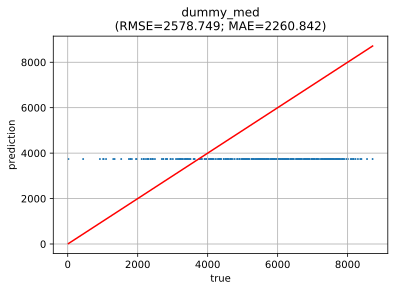

In [17]:
plot_scatter(testY, dummy_med.predict(testX), 'dummy_med')

## 2. Prediction with Linear Regression

First we will look at predicting the count using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [18]:
### INSERT YOUR CODE HERE

In [19]:
# check data format
print(trainX[0])
print(trainY[0])

[0.       0.       0.       0.344167 0.363625 0.805833 0.160446 1.
 0.       0.       0.       1.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       1.       0.       1.
 0.      ]
985


### Ordinary Least Squares

In [20]:
ols = linear_model.LinearRegression()
ols.fit(trainX, trainY)

LinearRegression()

### Ridge Regression with cross-validation on alpha

In [21]:
import numpy as np
alphas = np.logspace(-3,6,50)
rr = linear_model.RidgeCV(alphas = alphas, cv=5) 
rr.fit(trainX, trainY)

print("alpha =", rr.alpha_)
print("w =", rr.coef_)

alpha = 0.1599858719606059
w = [    0.          -243.6031091    127.0237448   1854.58337656
  1195.06609252 -1209.635737   -1740.78978726  -620.68283229
  -170.51654586   245.16766532   546.03171283  -748.37669998
  -567.03455874  -394.20370881   127.19672294   893.2797856
   638.62693385  -113.48075218     4.4866818    420.74162739
   212.82273929  -208.95057534  -265.10819581   -11.78373632
   -35.53288391     6.88462519   -37.41222018   -60.61241655
    10.09353115   128.36310062   647.0561676    339.58376981
  -986.6399374 ]


Compare the two models using the RMSE and MAE between the predictions and the true values.  Below is  code that will calculate evaluation for the training and test sets.

In [22]:
# ols is the linear regression model
trainerr['ols'] = eval_predict(trainY, ols.predict(trainX))
testerr['ols']  = eval_predict(testY, ols.predict(testX))
print("OLS: train RMSE, MAE =", trainerr['ols'])
print("OLS: test  RMSE, MAE =", testerr['ols'])

# rr is the ridge regression model
trainerr['rr'] = eval_predict(trainY, rr.predict(trainX))
testerr['rr']  = eval_predict(testY, rr.predict(testX))
print("RR: train RMSE, MAE =", trainerr['rr'])
print("RR: test  RMSE, MAE =", testerr['rr'])


OLS: train RMSE, MAE = (576.0255059992082, 433.74520547945207)
OLS: test  RMSE, MAE = (2324.512327960755, 2131.814207650273)
RR: train RMSE, MAE = (549.9374320904268, 407.29830510137907)
RR: test  RMSE, MAE = (2305.5571504842706, 2128.6157901270603)


### Which model has better prediction ability on the test set? Why?

The ridge regression model has better prediction ability on the test set.
Because it has smaller RMSE and MAE on the test set. Both RMSE and MAE describe the distance between the ground truth and the prediction. Smaller RMSE and MAE stand for more precise predictions.


Finally, we look at the scatter plot for ridge-regression.

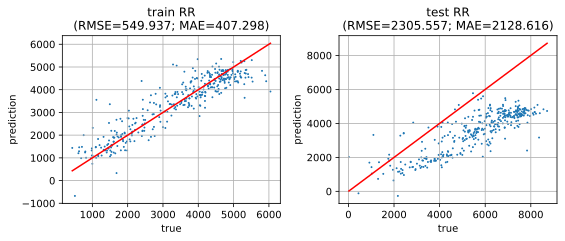

In [23]:
# rr is the ridge regression model
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, rr.predict(trainX), "train RR")
plt.subplot(1,2,2)
plot_scatter(testY, rr.predict(testX), "test RR")
plt.tight_layout()

### Do you notice anything interesting about the test predictions?  We'll see how to solve this problem later.

I noticed that the train set and the test set might have different data distributions.
Because our ridge regression model fits the data quite well on the train set (as the blue samples are dispersed uniformly in the red line) but fails on the test set.

# 3. Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model.

In [24]:
lasalphas = np.logspace(-3,2,50)
las = linear_model.LassoCV(alphas=lasalphas)
las.fit(trainX, trainY)

MSE = metrics.mean_squared_error(testY, las.predict(testX))
print("MSE =", MSE)

print("alpha =", las.alpha_)
print("w =", las.coef_)

MSE = 5396937.774087817
alpha = 3.7275937203149416
w = [    0.          -169.23477273    62.87498813  3017.34356868
     0.          -734.49474541 -1131.21844486 -1008.40174535
  -232.7173434     36.85087517   208.28844034  -419.56394013
  -253.76448902  -200.86282914     0.           732.67470389
   560.93505358   -17.19161717     0.           417.10741924
   348.64617846    -0.            -0.            -9.57747454
    -0.            23.17271555    -0.            -0.
    37.37827391    82.61429987   372.53364282    -0.
 -1337.87305108]


Examine the LASSO coefficients by sorting them in descending order.

In [25]:
# las is the trained LASSO model
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(las.coef_))[::-1]
# print out
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(las.coef_[i], featnames[i]))
print("bias = ", las.intercept_)

weight : feature description
 3017.344 : temp
-1337.873 : weathersit_3
-1131.218 : windspeed
-1008.402 : season_1
-734.495 : hum
 732.675 : mnth_5
 560.935 : mnth_6
-419.564 : mnth_1
 417.107 : mnth_9
 372.534 : weathersit_1
 348.646 : mnth_10
-253.764 : mnth_2
-232.717 : season_2
 208.288 : season_4
-200.863 : mnth_3
-169.235 : holiday
 82.614 : weekday_6
 62.875 : workingday
 37.378 : weekday_5
 36.851 : season_3
 23.173 : weekday_2
-17.192 : mnth_7
-9.577 : weekday_0
-0.000 : weekday_1
 0.000 : mnth_4
-0.000 : weekday_3
-0.000 : weathersit_2
-0.000 : weekday_4
 0.000 : mnth_8
 0.000 : atemp
-0.000 : mnth_11
-0.000 : mnth_12
 0.000 : yr
bias =  2541.664283212077


### Which features have largest affect on the predicted bike share count, and what is the interpretation?

Note that the features are normalized between 0 and 1 (or are binary values), so the weights corresponding to increase/decrease of bike count.  The bias term corresponds to the typical number of bikes used, which is modified based on the features.

The top influential features (weights > 1000) are:
- temp: Normalized temperature in Celsius.
- weathersit_3: Weather situation_3 ~ Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- windspeed: Normalized wind speed.
- season_1: Season1 ~ winter,

Feature 'temp' has a positive impact (#bikes↑) and the other three features have a negative impact (#bikes ↓) on the bike share count.
When the temperature increases, more share bikes. The impact is large.;
When the weather situation is Snow/Rain/Thunderstorm/Scattered clouds, fewer share bikes (nobody would like to go cycling in a snowy/rainy day);
When the wind speed increases, fewer share bikes;
In winter, fewer share bikes.

Here is a description of the features:
- `instant`: record index
- `dteday`: date
- `season`: season (1: winter, 2:spring, 3:summer, 4:fall)
- `yr`: year (0: 2011, 1:2012)
- `mnth`: month (1=Jan to 12=Dec)
- `holiday`: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday`: day of the week (1=Sunday to 7=Saturday)
- `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`: weather situation
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp`: Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

Now try feature selection using OMP.  You can try the top 10 features.

### OMP

In [26]:
omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=10) 
omp.fit(trainX, trainY)

MSE = metrics.mean_squared_error(testY, omp.predict(testX))
print("MSE =", MSE)

# sorting
inds = argsort(abs(omp.coef_))[::-1]
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(omp.coef_[i], featnames[i]))

MSE = 5239664.035442659
weight : feature description
 4376.661 : atemp
-1743.385 : windspeed
-1601.488 : weathersit_3
-1268.286 : hum
-905.306 : season_1
 692.078 : mnth_5
 582.947 : season_4
 569.421 : mnth_9
 491.558 : mnth_6
-300.600 : weathersit_2
 0.000 : weekday_0
 0.000 : weekday_3
 0.000 : holiday
 0.000 : workingday
 0.000 : temp
 0.000 : weathersit_1
 0.000 : weekday_6
 0.000 : weekday_5
 0.000 : weekday_4
 0.000 : season_2
 0.000 : season_3
 0.000 : mnth_1
 0.000 : mnth_12
 0.000 : mnth_2
 0.000 : mnth_3
 0.000 : mnth_4
 0.000 : weekday_2
 0.000 : mnth_7
 0.000 : mnth_8
 0.000 : weekday_1
 0.000 : mnth_10
 0.000 : mnth_11
 0.000 : yr


### LASSO
MSE = 5396937.774087817
alpha = 3.7275937203149416

3017.344 : temp
-1337.873 : weathersit_3
-1131.218 : windspeed
-1008.402 : season_1
-734.495 : hum
 732.675 : mnth_5
 560.935 : mnth_6
-419.564 : mnth_1
 417.107 : mnth_9
 372.534 : weathersit_1
 348.646 : mnth_10
-253.764 : mnth_2
-232.717 : season_2
 208.288 : season_4
-200.863 : mnth_3
-169.235 : holiday

### Do you get similar selected features? Why or why not?

By setting OMP with 10 non-zero coefficient, the obtained top-10 informative features are:
4376.661 : atemp
-1743.385 : windspeed
-1601.488 : weathersit_3
-1268.286 : hum
-905.306 : season_1
 692.078 : mnth_5
 582.947 : season_4
 569.421 : mnth_9
 491.558 : mnth_6
-300.600 : weathersit_2

Compared with LASSO's feature selection, the feature 'windspeed, weathersit_3, hum, season_1' are similar (top 5 informative feature in both LASSO and OMP). They all have the same sign (negative impacts on the bike share count).

But the OMP chooses 'atemp' as the most influential feature while the LASSO chooses 'temp'. It suggests that temperature is an important feature.
Feature 'atemp' and 'temp' might carry similar information, and LSSSO and OMP just choose one of them and omit the other.

# 4. Non-linear Regression
Now use non-linear regression to try to improve the prediction accuracy.  Use cross-validation on the training set to select the parameters. 

### Polynomial Regression

In [27]:
polylin = pipeline.Pipeline([('polyfeats', preprocessing.PolynomialFeatures(degree=1)),
                             ('linreg',    linear_model.LinearRegression()) ])

# degree=5, some error occurs
paramgrid = {"polyfeats__degree": array([1, 4])}

plincv = model_selection.GridSearchCV(polylin, paramgrid, cv=5, n_jobs=-1,
                                      scoring='neg_mean_squared_error')
plincv.fit(trainX, trainY)
print(plincv.best_params_)

MSE = metrics.mean_squared_error(testY, plincv.predict(testX))
print("MSE =", MSE)

{'polyfeats__degree': 4}
MSE = 5714013.334461794


### RBF Kernel SVR

In [28]:
paramgrid = {'C': logspace(-3,3,10),
             'gamma': logspace(-3,3,10),
             'epsilon': logspace(-2,2,10)}

svrcv = model_selection.GridSearchCV(svm.SVR(kernel='rbf'),paramgrid,
                                     scoring='neg_mean_squared_error', cv=5,
                                     n_jobs=-1, verbose=1)
svrcv.fit(trainX, trainY)
print(svrcv.best_params_)

MSE = metrics.mean_squared_error(testY, svrcv.predict(testX))
print("MSE =", MSE)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
{'C': 1000.0, 'epsilon': 0.01, 'gamma': 0.1}
MSE = 5979585.600832306


### Random Forest Regressor

In [29]:
paramgrid = {'max_depth': array([1, 5, 10, 20, 50]), 'n_estimators': array([10, 50, 100, 200, 400])}

rfcv = model_selection.GridSearchCV(ensemble.RandomForestRegressor(random_state=0), 
                                    paramgrid, cv=5, n_jobs=-1, verbose=True)
rfcv.fit(trainX, trainY)
print(rfcv.best_params_)

MSE = metrics.mean_squared_error(testY, rfcv.predict(testX))
print("MSE =", MSE)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'max_depth': 50, 'n_estimators': 200}
MSE = 4875492.903274112


### Gaussian Process Regressor

In [30]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
kernels = [  DotProduct()    + WhiteKernel(), 
             DotProduct()**2 + WhiteKernel(), 
             DotProduct()**3 + WhiteKernel(),
             RBF()           + WhiteKernel()   ]
gpr = {}
for i,k in enumerate(kernels):
    gpr[i] = gaussian_process.GaussianProcessRegressor(kernel=k, random_state=0, normalize_y=True)
    gpr[i].fit(trainX, trainY)
    
    print('kernel: ', k)
    MSE = metrics.mean_squared_error(testY, gpr[i].predict(testX))
    print("MSE =", MSE)
    
gpr = gaussian_process.GaussianProcessRegressor(kernel=kernels[1], random_state=0, normalize_y=True)

kernel:  DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)
MSE = 5317394.243923928
kernel:  DotProduct(sigma_0=1) ** 2 + WhiteKernel(noise_level=1)
MSE = 4932964.507578113
kernel:  DotProduct(sigma_0=1) ** 3 + WhiteKernel(noise_level=1)
MSE = 5402227.953382415
kernel:  RBF(length_scale=1) + WhiteKernel(noise_level=1)
MSE = 5488971.942035984


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__kernel__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


In [31]:
# polynomial regression
plincv_MSE = metrics.mean_squared_error(testY, plincv.predict(testX))
plincv_MAE = metrics.mean_absolute_error(testY, plincv.predict(testX))
print('polynomial regression MSE:', plincv_MSE)
print('polynomial regression MAE:', plincv_MAE)

# RBF kernel SVR
svrcv_MSE = metrics.mean_squared_error(testY, svrcv.predict(testX))
svrcv_MAE = metrics.mean_absolute_error(testY, svrcv.predict(testX))
print('RBF kernel SVR MSE:', svrcv_MSE)
print('RBF kernel SVR MAE:', svrcv_MAE)

# random forest
rfcv_MSE = metrics.mean_squared_error(testY, rfcv.predict(testX))
rfcv_MAE = metrics.mean_absolute_error(testY, rfcv.predict(testX))
print('random forest SVR MSE:', rfcv_MSE)
print('random forest SVR MAE:', rfcv_MAE)

# GPR
gpr_MSE = metrics.mean_squared_error(testY, gpr.predict(testX))
gpr_MAE = metrics.mean_absolute_error(testY, gpr.predict(testX))
print('GPR MSE:', gpr_MSE)
print('GPR MAE:', gpr_MAE)

polynomial regression MSE: 5714013.334461794
polynomial regression MAE: 2146.553158824759
RBF kernel SVR MSE: 5979585.600832306
RBF kernel SVR MAE: 2245.763661227526
random forest SVR MSE: 4875492.903274112
random forest SVR MAE: 2055.288401639344
GPR MSE: 34549856.972677596
GPR MAE: 5599.934426229508


Make a scatter plot of the best regressor. Call it `bestr`.

In [32]:
# scatter plot of the best regressor (bestr)
def plot_result(bestr, trainY):
    plt.figure(figsize=(8,3.5))
    plt.subplot(1,2,1)
    plot_scatter(trainY, bestr.predict(trainX), "train")
    plt.subplot(1,2,2)
    plot_scatter(testY, bestr.predict(testX), "test")
    plt.tight_layout()

Random Forest Regressor


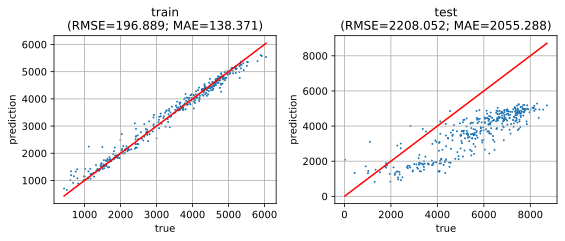

In [33]:
print('Random Forest Regressor')
plot_result(rfcv, trainY)

RBF Kernel SVR


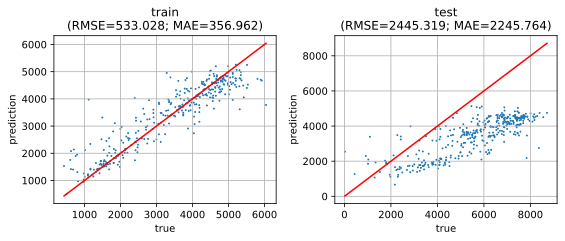

In [34]:
print('RBF Kernel SVR')
plot_result(svrcv, trainY)

### Which regression method performs the best? Why do you think so?

I estimate the performance of above regression model by calculating MSE and MAE on test set.

MSE: Gaussian Process Regerssor >> RBF Kernel SVR > Polynomial Regression > Random Forest Regressor
MAE: Gaussian Process Regerssor >> RBF Kernel SVR ≈ Polynomial Regression ≈ Random Forest Regressor

So Random Forest Regressor is better, since it has relatively smaller MSE and MAE.
From the above plots, the Random Forest Regressor fits well on train set (better than RBF Kernel SVR), but they have similar performance on the test set.


# 5. Test set bias

In your scatter plot above, you may have noticed that the regressor is almost always under-predicting the count (the points are usually below the red line). This suggests that there is some bias in the test set.

Let's look at the plot of the count over time.  The left side is the training data (1st year), and the right side is the testing data (2nd year)

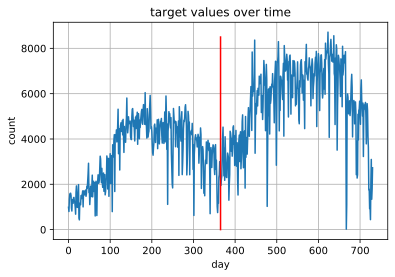

In [35]:
plt.plot(dataY)
plt.plot([365,365], [0,8500], 'r')
plt.grid(True)
plt.xlabel('day')
plt.ylabel('count')
plt.title('target values over time');

Interestingly, it looks like bike sharing became more popular in the 2nd year, so the overall counts are higher (but the seasonal trend looks the same).

Let's assume that we noticed this upward trend in the first 3 months of the year, and collected the data for training.  We will then use the remaining part of the 2nd year for testing.

In [36]:
# get indices for month 1 to month 3
print(featnames[11], featnames[12], featnames[13])
inds = (testX[:,11].ravel()==1) + (testX[:,12].ravel()==1) + (testX[:,13].ravel()==1)

# new training data from 2nd year (months 1-3)
trainX2 = testX[inds]
trainY2  = testY[inds]
# new testing data from 2nd year (months 4-12)
testX2  = testX[logical_not(inds)]
testY2   = testY[logical_not(inds)]
print(trainX2.shape)
print(testX2.shape)

mnth_1 mnth_2 mnth_3
(91, 33)
(275, 33)


There are several approaches for using the new data:
1. use the new data to train the regressor, and ignore the old data.
2. append the new data with the old data and train a regressor.  Note that we kept the "year" feature, so the regressor can distinguish the new and old training data.
3. use the new data to train a regressor on the residual error of the old regressor.  The residual error is the difference between the predicted count and true count on the new training data.

Using **one selected** regression method, try each of the approaches above to use the new data. You should compare the 3 approaches with the regressor trained on the original data and tested on the new test set (`testY2`).

In [37]:
# append new data with old data
trainY2_append = concatenate((trainY, trainY2), axis=0)
trainX2_append = concatenate((trainX, trainX2), axis=0)
print(trainY2_append.shape)
print(trainX2_append.shape)

(456,)
(456, 33)


## Selection: Random Forest Regressor

### Method 1: use the new data to train the regressor, and ignore the old data.

In [38]:
# scatter plot of the best regressor (bestr)
def plot_result2(bestr, trainX, trainY, testX, testY):
    plt.figure(figsize=(8,3.5))
    plt.subplot(1,2,1)
    plot_scatter(trainY, bestr.predict(trainX), "train")
    plt.subplot(1,2,2)
    plot_scatter(testY, bestr.predict(testX), "test")
    plt.tight_layout()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'max_depth': 20, 'n_estimators': 10}
MSE = 1583105.6717818181
Random Forest Regressor - Method 1


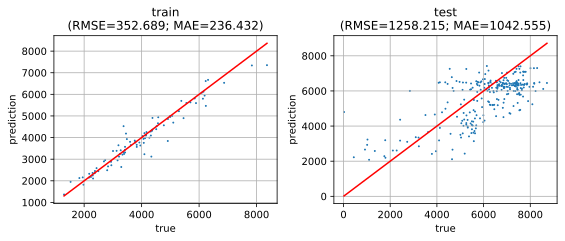

In [39]:
paramgrid = {'max_depth': array([1, 5, 10, 20, 50]), 'n_estimators': array([10, 50, 100, 200, 400])}

rfcv = model_selection.GridSearchCV(ensemble.RandomForestRegressor(random_state=0), 
                                    paramgrid, cv=5, n_jobs=-1, verbose=True)
rfcv.fit(trainX2, trainY2)
print(rfcv.best_params_)

MSE = metrics.mean_squared_error(testY2, rfcv.predict(testX2))
print("MSE =", MSE)

print('Random Forest Regressor - Method 1')
plot_result2(rfcv, trainX2, trainY2, testX2, testY2)

### Method 2: append the new data with the old data and train a regressor. Note that we kept the "year" feature, so the regressor can distinguish the new and old training data.

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'max_depth': 20, 'n_estimators': 200}
MSE = 1517325.4998648677
Random Forest Regressor - Method 1


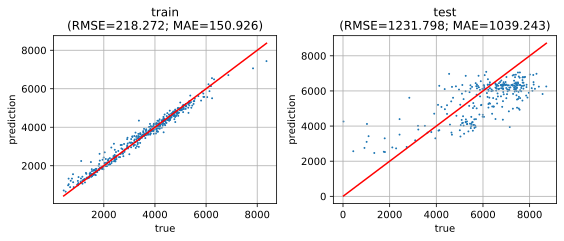

In [40]:
paramgrid = {'max_depth': array([1, 5, 10, 20, 50]), 'n_estimators': array([10, 50, 100, 200, 400])}

rfcv = model_selection.GridSearchCV(ensemble.RandomForestRegressor(random_state=0), 
                                    paramgrid, cv=5, n_jobs=-1, verbose=True)
rfcv.fit(trainX2_append, trainY2_append)
print(rfcv.best_params_)

MSE = metrics.mean_squared_error(testY2, rfcv.predict(testX2))
print("MSE =", MSE)

print('Random Forest Regressor - Method 1')
plot_result2(rfcv, trainX2_append, trainY2_append, testX2, testY2)

### Method 3: use the new data to train a regressor on the residual error of the old regressor. The residual error is the difference between the predicted count and true count on the new training data.
#### 1. Old regressor
 - Use the best parameters of the previous cross validation results.

In [41]:
rf = ensemble.RandomForestRegressor(random_state=0, max_depth=50, n_estimators = 200)
rf.fit(trainX, trainY)

resid = trainY2 - rf.predict(trainX2)

#### 2. New regressor on residual error of the old regressor
 - train_res_X = trainY2
 - train_res_Y = resid
 
 - Input testX. Compute predY = pred(testX) & predRes = pred(predY). Output predY + predRes

In [42]:
print(trainY2.shape)
print(resid.shape)

(91,)
(91,)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'max_depth': 2, 'n_estimators': 90}


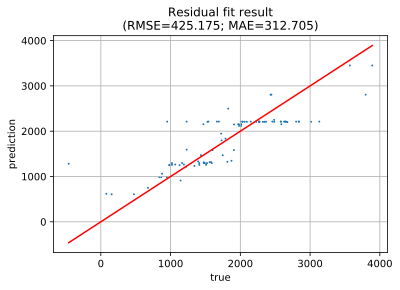

In [43]:
train_res_X = trainY2.reshape(-1, 1) 
train_res_Y = resid

paramgrid = {'max_depth': array([1, 2, 3, 5, 10]), 'n_estimators': array([5, 10, 50, 60, 70, 80, 90, 100])}

rfcv_res = model_selection.GridSearchCV(ensemble.RandomForestRegressor(random_state=0), 
                                        paramgrid, cv=5, n_jobs=-1, verbose=True)

rfcv_res.fit(train_res_X, train_res_Y)
print(rfcv_res.best_params_)

plt.plot()
plot_scatter(train_res_Y, rfcv_res.predict(train_res_X), "Residual fit result")

#### 3. Combine two regressor: old regressor and residual regressor
 - old regressor: rf
 - residual regressor: rfcv_res

Bike share prediction result


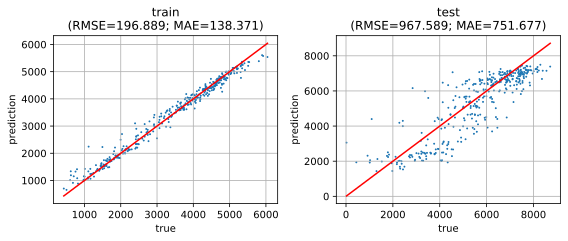

In [44]:
old_pred = rf.predict(testX)

res_pred = rfcv_res.predict(old_pred.reshape(-1, 1))

final_pred = old_pred + res_pred

print('Bike share prediction result')
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, rf.predict(trainX), "train")
plt.subplot(1,2,2)
plot_scatter(testY, final_pred, "test")
plt.tight_layout()

### Which approach for using the new data is better? Explain why you think the other approaches don't work well.

Result:
 - Method 1: RMSE = 1258.2  MAE = 1042.6
 - Method 2: RMSE = 1231.8  MAE = 1039.2
 - Method 3: RMSE = 967.59  MAE = 751.67

Conclusion:
Method 3 is better, it has a smaller RMSE and MAE.

Reason (by explaining why each works or why it fails):
 - Method 1: it uses the samples of Y2 month 1\~3 to train and the samples of Y2 month 4\~12 to test the regressor. The regressor only sees the bike share trend of Y2 month 1\~3. When it is used to predict the bike share trend of Y2 month 4\~12, it has not adequate knowledge of the samples in Y2 month 4\~12 and thus output poor prediction (the month and the bike share count are not independent). Meanwhile, the training set might be too small (only 91 sanples).
 
- Method 2: it uses the samples of Y1 + Y2 month 1\~3 to train and the samples of Y2 month 4\~12 to test the regressor. Method 2 performs slightly better than Method 1. The 'year' feature is preversed in the train data, but this feature might be considered less important by the regressor thus do not have too much impacts on the final predictions.

- But for Method 3, it directly models the residual error between Y1 and Y2 (making the differences between Y1 and Y2 more clear). I think Method 3 still have the problem 'the month and the bike share count are not independent', so we cannot simply provide the regressor with samples in month 1\~3 and ask it to predict the trend in month 4\~12.